### Overfitting

In this notebook we demonstrate the effects of overfitting and show some techniques to combat it. We will be using a CNN-based binary classifier on the famous [cat vs dogs](https://www.kaggle.com/c/dogs-vs-cats/data) dataset.

In [46]:
import os
import cv2
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, Dense, Dropout, Flatten, Input, MaxPooling2D
from tensorflow.keras import Model
from time import time
from sklearn.model_selection import train_test_split
from tqdm import tqdm

from matplotlib import pyplot as plt
plt.rcParams['figure.figsize'] = [15, 10]

# Set the seeds for reproducibility
from numpy.random import seed
from tensorflow.random import set_seed
seed_value = 1234578790
seed(seed_value)
set_seed(seed_value)

#### Dataset

Let's very briefly inspect the dataset.

In [47]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)import os

import torchvision.transforms.functional as TF

import zipfile
import glob
from PIL import Image
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import torchvision
from torchvision import datasets, transforms
import torchvision.models as models
from datetime import datetime
import wandb
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
import random
random_state = 2137
np.random.seed(random_state)
torch.manual_seed(random_state)
torch.cuda.manual_seed(random_state)

In [48]:
#reading csv
annotations = pd.read_csv('./data/annotations/list.txt')

#The first 4 rows consists of the information about breeds
#Reading the data after 5th row
annotations = annotations.loc[5:,]

#Processing the columns
annotations[['CLASS-ID','SPECIES','BREED','ID']] = annotations['#Image CLASS-ID SPECIES BREED ID'].str.split(expand=True) 

#Dropping unnecessary columns
annotations = annotations.drop('#Image CLASS-ID SPECIES BREED ID',axis=1)

#renaming the columns
annotations = annotations.rename(columns={"CLASS-ID": "image", "SPECIES": "CLASS-ID", 'BREED' : "SPECIES", "ID":"BREED ID"})


#converting the object type to int type
annotations[["CLASS-ID","SPECIES","BREED ID"]] = annotations[["CLASS-ID","SPECIES","BREED ID"]].astype(int)

In [49]:
annotations

,image,CLASS-ID,SPECIES,BREED ID
5,Abyssinian_100,1,1,1
6,Abyssinian_101,1,1,1
7,Abyssinian_102,1,1,1
8,Abyssinian_103,1,1,1
9,Abyssinian_104,1,1,1
...,...,...,...,...
7349,yorkshire_terrier_96,37,2,25
7350,yorkshire_terrier_97,37,2,25
7351,yorkshire_terrier_98,37,2,25
7352,yorkshire_terrier_99,37,2,25


RUN THIS CELL ONLY ONCE!!!

In [50]:
# adding the extension to image so it can be used to access the real image
annotations['image'] = annotations['image'].apply(lambda x : str(x)+'.jpg')
annotations = annotations.reset_index()
annotations = annotations.drop('index',axis=1)

#Extracting the classname/breed of the animal
annotations['classname'] = annotations['image'].apply(lambda x: str(x)[:str(x).rindex('_')])

# Adding information about cat or dog based on the 'Species' column to the 'classname' column
annotations['classname'] = annotations.apply(lambda row: f"{('dog' if row['SPECIES'] == 2 else 'cat')}_{row['classname']}", axis=1)
annotations

,image,CLASS-ID,SPECIES,BREED ID,classname
0,Abyssinian_100.jpg,1,1,1,cat_Abyssinian
1,Abyssinian_101.jpg,1,1,1,cat_Abyssinian
2,Abyssinian_102.jpg,1,1,1,cat_Abyssinian
3,Abyssinian_103.jpg,1,1,1,cat_Abyssinian
4,Abyssinian_104.jpg,1,1,1,cat_Abyssinian
...,...,...,...,...,...
7344,yorkshire_terrier_96.jpg,37,2,25,dog_yorkshire_terrier
7345,yorkshire_terrier_97.jpg,37,2,25,dog_yorkshire_terrier
7346,yorkshire_terrier_98.jpg,37,2,25,dog_yorkshire_terrier
7347,yorkshire_terrier_99.jpg,37,2,25,dog_yorkshire_terrier


In [54]:
class CatsDogsDataset(Dataset):    
    def __init__(self, file_list, transform=None):
        self.folder_patch = './data/images/'
        self.annotations = file_list
        self.transform = transform
        self.filelength = len(file_list)

    def __len__(self):
        return self.filelength

    def __getitem__(self, idx):
        classID = self.annotations['CLASS-ID'].iloc[idx]
        img_path = self.annotations['image'].iloc[idx]        
        img_path = self.folder_patch + img_path
        img = Image.open(img_path)
        
        has_alpha_channel = img.mode == 'RGBA'
        if has_alpha_channel == True:
            print("image has Alpha channel")
            img = img.convert('RGB')
        if self.transform is not None:
            try:                
                img = self.transform(img)
            except RuntimeError as e:
                print(f"Exception: {e}")
                print("Shape before normalization:", img.size)
                print(img_path)
                tot = transforms.ToTensor()
                img_tensor = tot(img)
                print("Input Tensor Shape:", img_tensor.shape)
                print("Input Tensor Values:", img_tensor)
        #else:
            #print("No transformations to be done")
        return img, classID-1

In [55]:
size = 64, 64
resize_func = lambda img: img.resize(size)
all_images = CatsDogsDataset(annotations, resize_func)

In [56]:
all_images[1]

(<PIL.Image.Image image mode=RGB size=64x64>, 0)

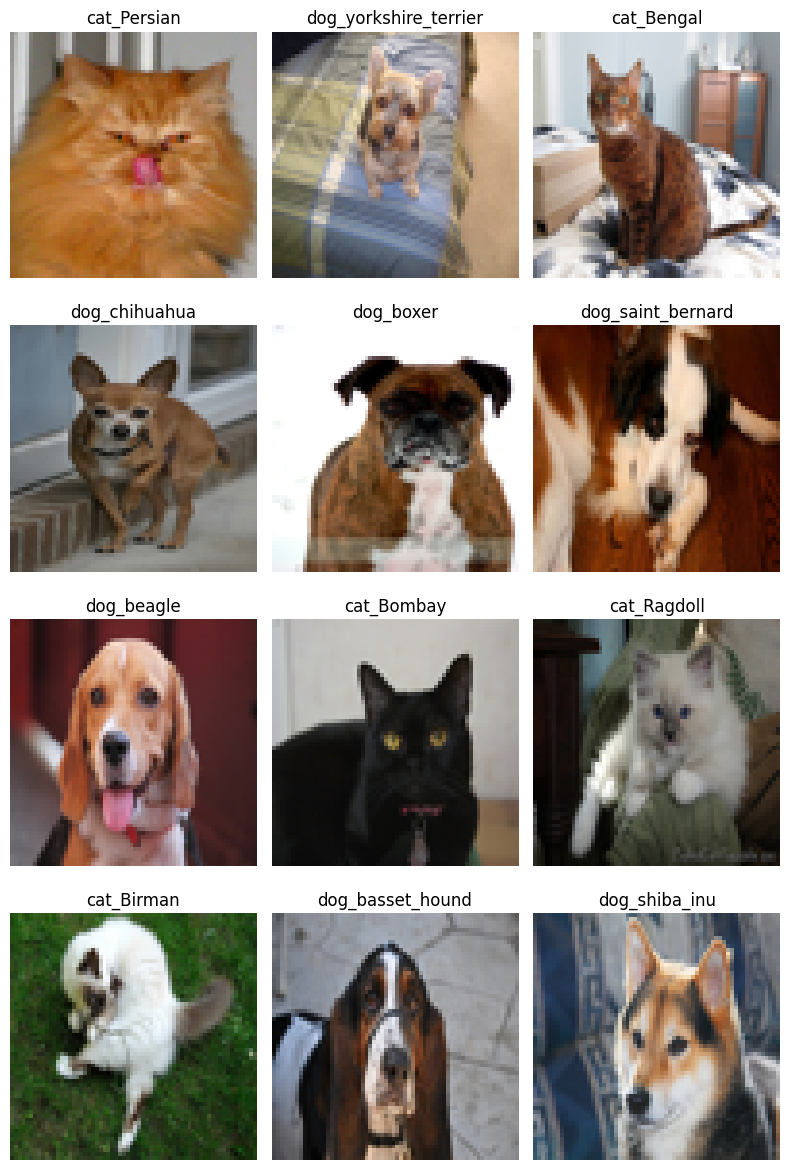

In [59]:
num_images = 12
plt.figure(figsize=(8, 12))
for i in range(num_images):
    idx = random.randint(0, len(all_images) - 1)
    image, classID = all_images[idx]
    classname = all_images.annotations['classname'].iloc[idx]
    plt.subplot(4, 3, i+1)
    plt.imshow(image)
    plt.title(classname)
    plt.axis('off')
plt.tight_layout()
plt.show()

Now it is the time to load the data. We will normalize the dimensions to a specific image size.

Let's split the data into training and validation subsets and normalize the pixel values.

ValueError: num must be an integer with 1 <= num <= 12, not 13

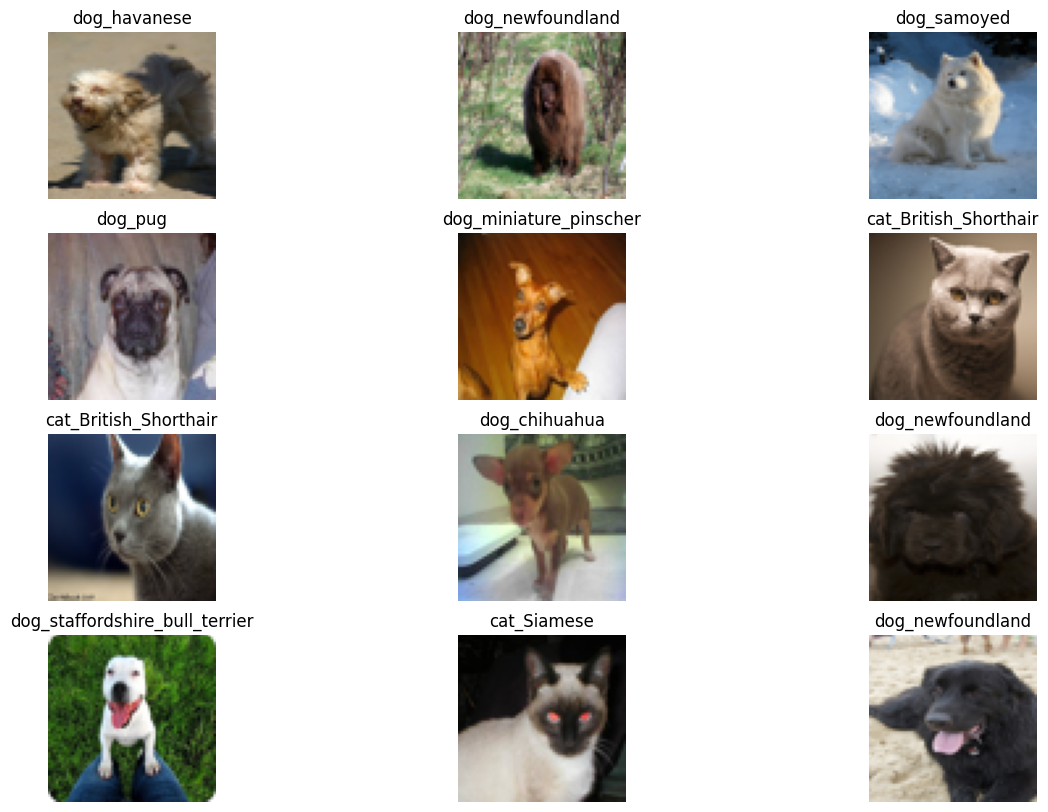

In [60]:
images, classes = [],[]
for i in range(len(all_images)):
    image, _ = all_images[i]
    

In [ ]:
classes[1500]

In [39]:
x_train, x_test, y_train, y_test = train_test_split(images, classes, train_size=0.8, shuffle=True)

x_train = np.array(x_train)/255
x_test = np.array(x_test)/255

y_train = np.array(y_train)
y_test = np.array(y_test)

print(x_train.shape, len(y_train))

(5879, 64, 64, 3) 5879


In [43]:
y_train[0]

31

### Dog vs Cat Classification

We will start by building a simple CNN-based binary classifier.

In [40]:
inputs = Input(shape=(size, size, 3))

net = Conv2D(32, kernel_size=(3, 3), activation="relu", padding='same')(inputs)
net = MaxPooling2D(pool_size=(2, 2))(net)
net = Conv2D(64, kernel_size=(3, 3), activation="relu", padding='same')(net)
net = MaxPooling2D(pool_size=(2, 2))(net)
net = Conv2D(128, kernel_size=(3, 3), activation="relu", padding='same')(net)
net = MaxPooling2D(pool_size=(2, 2))(net)
net = Flatten()(net)
net = Dense(128, activation="relu")(net)
outputs = Dense(1, activation="sigmoid")(net)

model = Model(inputs, outputs)
model.summary()

ValueError: Invalid dtype: tuple

And let's start training ;-)

In [ ]:
epochs = 50
batch_size = 64

print(x_train.shape)

model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])

start = time()
history = model.fit(x_train, y_train, batch_size=batch_size, epochs=epochs, validation_data=(x_test, y_test))
print('Elapsed time', time() - start)

In [ ]:
def plot_history(history):
    h = history.history
    epochs = range(len(h['loss']))

    plt.subplot(121), plt.plot(epochs, h['loss'], '.-', epochs, h['val_loss'], '.-')
    plt.grid(True), plt.xlabel('epochs'), plt.ylabel('loss')
    plt.legend(['Train', 'Validation'])
    plt.subplot(122), plt.plot(epochs, h['accuracy'], '.-',
                               epochs, h['val_accuracy'], '.-')
    plt.grid(True), plt.xlabel('epochs'), plt.ylabel('Accuracy')
    plt.legend(['Train', 'Validation'])
        
    print('Train Acc     ', h['accuracy'][-1])
    print('Validation Acc', h['val_accuracy'][-1])
    
plot_history(history)

This experiment suffers from a considerable overfitting (the training loss and accuracy are far better than the validation performance). We need to apply some of the techniques seen in the lectures to combat this effect.

### Regularizations

To reduce the negative effect of overfitting, we will insert droput layers after each convolution and before the last fully connected layer. Furthermore, we reduce the size of the dense layer after flatten. Note that reducing the network complexity is also a form of regularization.

In [ ]:
inputs = Input(shape=(size, size, 3))

net = Conv2D(32, kernel_size=(3, 3), activation="relu", padding='same')(inputs)
net = MaxPooling2D(pool_size=(2, 2))(net)
net = Dropout(0.2)(net)
net = Conv2D(64, kernel_size=(3, 3), activation="relu", padding='same')(net)
net = MaxPooling2D(pool_size=(2, 2))(net)
net = Dropout(0.2)(net)
net = Conv2D(128, kernel_size=(3, 3), activation="relu", padding='same')(net)
net = MaxPooling2D(pool_size=(2, 2))(net)
net = Dropout(0.2)(net)
net = Flatten()(net)
net = Dense(64, activation="relu")(net)
net = Dropout(0.5)(net)
outputs = Dense(1, activation="sigmoid")(net)

model = Model(inputs, outputs)
model.summary()

In [ ]:
epochs = 50
batch_size = 64

print(x_train.shape)

model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])

start = time()
history = model.fit(x_train, y_train, batch_size=batch_size, epochs=epochs, validation_data=(x_test, y_test))
print('Elapsed time', time() - start)

In [ ]:
plot_history(history)

The results look better now but there is still a significat performance gap between training and validation.

### Data Augmentation

As a next step, data augmentation is applied. We build a data generator and, in this simple example, we will add the so called *mirroring* as the only augmentation technique. In general, there is a large variety of augmentation you can experiment with (gamma correction, adding noise, blurring, sharpening, brightness modification, color (un)balancing, etc.).

Note that data augmentation is applied only to training data.

In [ ]:
from sklearn.utils import shuffle

def datagen(x, y, batch_size):
    num_samples = len(y)
    while True:
        for idx in range(0, num_samples, batch_size):
            x_ = x[idx:idx + batch_size, ...]
            y_ = y[idx:idx + batch_size]
            
            if len(y_) < batch_size:
                x, y = shuffle(x, y)
                break
            
            # Augmentation
            for idx_aug in range(batch_size):
                if np.random.rand() > 0.5:
                    x_[idx_aug, ...] = np.fliplr(x_[idx_aug, ...])                                
                    
            yield x_, y_

In [ ]:
inputs = Input(shape=(size, size, 3))

net = Conv2D(32, kernel_size=(3, 3), activation="relu", padding='same')(inputs)
net = MaxPooling2D(pool_size=(2, 2))(net)
net = Dropout(0.2)(net)
net = Conv2D(64, kernel_size=(3, 3), activation="relu", padding='same')(net)
net = MaxPooling2D(pool_size=(2, 2))(net)
net = Dropout(0.2)(net)
net = Conv2D(128, kernel_size=(3, 3), activation="relu", padding='same')(net)
net = MaxPooling2D(pool_size=(2, 2))(net)
net = Dropout(0.2)(net)
net = Flatten()(net)
net = Dense(64, activation="relu")(net)
net = Dropout(0.5)(net)
outputs = Dense(1, activation="sigmoid")(net)

model = Model(inputs, outputs)
model.summary()

In [ ]:
epochs = 50
batch_size = 64
steps_per_epoch = len(y_train) // batch_size
generator = datagen(x_train, y_train, batch_size)
print(x_train.shape)

model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])

start = time()
history = model.fit(generator, steps_per_epoch=steps_per_epoch, epochs=epochs, validation_data=(x_test, y_test))
print('Elapsed time', time() - start)

In [ ]:
plot_history(history)

The results look much better now. Even though the training accuracy is lower than before, the important thing is that validation performance has increased and is above 90% of accuracy now. We can further experiment with different (more complex) architectures and more complex data augmentators.